In [1]:
import numpy as np
import math
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Mục mới

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# GBSG2 data

In [94]:
GBSG = pd.read_csv('/content/sample_data/GBSG2.csv', sep = ";")
GBSG.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


In [256]:
d = GBSG.cens
y = GBSG.time

s = y/30
X = GBSG.drop(['time', 'cens'], axis = 1)
c_obj = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, prefix=c_obj, drop_first = True)

X.head()

,age,tsize,pnodes,progrec,estrec,horTh_yes,menostat_Pre,tgrade_II,tgrade_III
0,70,21,3,48,66,0,0,1,0
1,56,12,7,61,77,1,0,1,0
2,58,35,9,52,271,1,0,1,0
3,59,17,4,60,29,1,0,1,0
4,73,35,1,26,65,0,0,1,0


In [257]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# Multi-task logistic regression (MTLR)

MTLR directly models the discret survival function. MTLR considers time-varying effects of featrues and also censored observations. We use MLE estimation to obtain the parameters of MTLR.

Considering an observation with survival time $s$, we use a binary vector $y = (y_1, y_2, ..., y_m)$ to encode the survival status at each time $t_i$: $y_i = 1$ if $t_i > s$ and $y_i = 1$ if $t_i < s$. For example, we model in the period of 60 years, an individual died at time 24.5, then $y_1,...,y_{24} = 0$ and $y_{25},...,y_{60} = 1$. 

We have m+1 possible survival status and the probability of observing the survival status sequence $y = (y_1, y_2, ..., y_m)$ can be defined by the following:

$$P(Y = (y_1, y_2, ..., y_m)|X) = \frac{exp(\sum_{i=1}^my_i(W_iX+b_i))}{\sum_{k=0}^m exp(f(X,k))}$$
With $W_i$, $b_i$ vector of coefficients and intercept coefficient at time $i$ and  $f(X,k)=\sum_{i=k+1}^m(W_iX+b_i)$, with $f(X,m) = 0$.

This is what we put in the likelihood function for uncensored observations.


For censored observations at time $s_c$ and $t_j$ is the closet time point after $s_c$, we encode vector $y$ the same as death event. We define the survival probability function as the sum of the probability of all survival status for $T>t_j$:
$$P(T>t_j|X) = \frac{\sum_{k=j}^m exp(f(X,k))}{\sum_{k=0}^m exp(f_(X,k))}$$

Instead of maximizing the log likelihood function, we minimize the loss function equal to minus log likelihood plus the regulation terms
$$-\sum_{i=1}^n \bigg[\sum_{j=1}^m\bigg(d_jy_j(s_i)(W_iX_i+b_j) +(1-d_j)\sum _{k=j_i}^mf(X,k)-\sum _{k=0}^mf(X,k)\bigg) \bigg]+\frac{C_1}{2}\sum_{j=1}^m||W_j||^2 + \frac{C_2}{2}\sum_{j=1}^{m-1}||W_{j+1}-W_{j}||^2$$ 

The second term prevents overfitting. The third term ensures the parameters vary smoothly across consecutive time points, which means $W_i$ and $W_{i+1}$ will be not too much different therefor the survival probability function will be quite smooth. 

# Implimentation in Python, Tensorflow

Calculate $m$ and some useful matrices which help us define loss function under matrix form

In [258]:
from sklearn.model_selection import train_test_split

X_train, X_test, s_train, s_test, d_train, d_test = train_test_split(X, s, d, test_size=0.1, random_state=12)

d=np.array(d_train)
s=np.array(s_train)
X=np.array(X_train)

d_test=np.array(d_test)
s_test=np.array(s_test)
X_test=np.array(X_test)

In [266]:
T = np.ceil(s)
m = math.ceil(np.max(s))
n = len(s)
stat = np.repeat(np.arange(0,m+1,1),n).reshape(-1,n).T >= s.reshape(n,-1)
y = stat[:,1:]
theta = np.tril(np.ones((m, m+1)))
b = np.random.rand(1,m) 
b = b - np.mean(b)
W = np.random.rand(X.shape[1],m) 
W = W - np.mean(W)
r_W = np.eye(W.shape[1],W.shape[1]-1,k=-1) - np.eye(W.shape[1],W.shape[1]-1,k=0)

Using gradient descent to optimize the objective function. We can do it easily in **Tensorflow**.

Attention to overflow problem: clipping small value for some values approach 0 prevent logarit returns $-Inf$ and avoiding exponential of too large value returns $Inf$. That will make our program crash.

In [364]:
lnr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = 0.0001, decay_steps=2000, end_learning_rate=0.000001, power=1.0,
    cycle=False, name=None
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lnr)

In [365]:
clipped = lambda x: tf.maximum(x, 1e-300)

C1 = 10
C2 = 20
for i in range(2000):
    W = tf.Variable(W)
    b = tf.Variable(b)
    with tf.GradientTape() as tape:
        fxk = (X @ W +b) @ theta
        #max_Mxk = tf.math.reduce_max(Mxk, axis = 1, keepdims = True)
        expfxk = tf.exp(fxk)# - max_Mxk)
        num_uncensored = tf.reduce_sum(y * (X @ W + b), axis = 1) #- tf.math.log(tf.reduce_sum(expMxk, axis = 1)) #- tf.reduce_sum(max_Mxk, axis = 1)
        num_censored = tf.math.log(clipped(tf.reduce_sum(expfxk * stat, axis = 1))) #- tf.math.log(tf.reduce_sum(expMxk, axis = 1))
        minus_log_likelihood = -tf.reduce_sum(tf.math.multiply(d , num_uncensored) + tf.math.multiply(1-d , num_censored) - tf.math.log(tf.reduce_sum(expfxk, axis = 1)))
        regulizer_ridge = C1 / 2 * tf.reduce_sum(W*W)
        regulizer_smooth = C2 / 2 * (tf.reduce_sum((W @ r_W) * (W @ r_W)) + tf.reduce_sum(tf.experimental.numpy.diff(b)*tf.experimental.numpy.diff(b)))
        loss = minus_log_likelihood + regulizer_ridge + regulizer_smooth
        if (i%100==0):
            print(loss)
    grad = tape.gradient(loss, [W,b])
    optimizer.apply_gradients(zip(grad, [W,b]))

tf.Tensor(1333.75110296553, shape=(), dtype=float64)
tf.Tensor(1333.7011899093, shape=(), dtype=float64)
tf.Tensor(1333.6833779335357, shape=(), dtype=float64)
tf.Tensor(1333.6810793252098, shape=(), dtype=float64)
tf.Tensor(1333.6830286267616, shape=(), dtype=float64)
tf.Tensor(1333.6838967590345, shape=(), dtype=float64)
tf.Tensor(1333.6839036034817, shape=(), dtype=float64)
tf.Tensor(1333.6832444057084, shape=(), dtype=float64)
tf.Tensor(1333.6820894278474, shape=(), dtype=float64)
tf.Tensor(1333.6805843763511, shape=(), dtype=float64)
tf.Tensor(1333.6779167026364, shape=(), dtype=float64)
tf.Tensor(1333.6737054250907, shape=(), dtype=float64)
tf.Tensor(1333.667854578515, shape=(), dtype=float64)
tf.Tensor(1333.6590039696769, shape=(), dtype=float64)
tf.Tensor(1333.6412197389272, shape=(), dtype=float64)
tf.Tensor(1333.6262828181982, shape=(), dtype=float64)
tf.Tensor(1333.6126529134174, shape=(), dtype=float64)
tf.Tensor(1333.5995030310369, shape=(), dtype=float64)
tf.Tensor(1333.5

We plot predicted survival probability curve of some observation.

In [366]:
expfxk = expfxk[:,::-1]
eM = np.cumsum(expfxk, axis = 1)
eM = eM[:,::-1]
prob = eM/eM[:,0].reshape(-1,1)

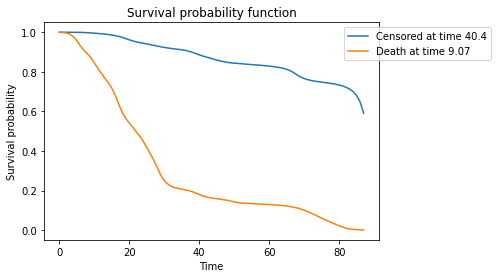

In [367]:
plt.plot(prob[0,0:88], label='Censored at time 40.4')
plt.plot(prob[1,0:88], label='Death at time 9.07')
plt.title("Survival probability function")
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.legend(bbox_to_anchor=( 1.35, 1.))
plt.show()

### Prediction on test set

In [368]:
fxk_test = (X_test @ W +b) @ theta
expfxk_test = tf.exp(fxk_test)

In [369]:
expfxk_test = expfxk_test[:,::-1]
eM_test = np.cumsum(expfxk_test, axis = 1)
eM_test = eM_test[:,::-1]
prob_test = eM_test/eM_test[:,0].reshape(-1,1)

In [370]:
ind1=np.where(d_test == 1)
ind0=np.where(d_test == 0)

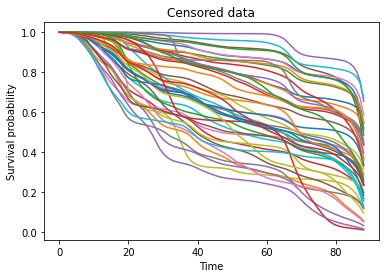

In [379]:
plt.plot(prob_test[ind0][:,0:89].T)
plt.title("Censored data")
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.show()

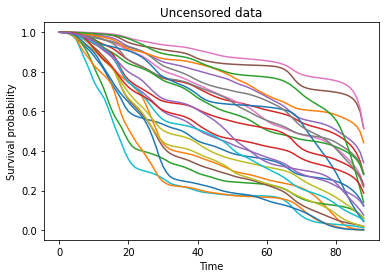

In [380]:
plt.plot(prob_test[ind1][:,0:89].T)
plt.title("Uncensored data")
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.show()

**Works to do next**: 

*   Try to feature engineering.
*   Tune the hyper-parameters and find the best using cross validation.
*   Study some metrics to evaluate the quality of the model and compare with other models.
*   Tune the hyper-parameters and find the best using cross validation.